In [1]:
import pandas as pd
import numpy as np
import statistics
import xgboost as xgb
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.utils.multiclass import type_of_target
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import tree
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, plot_confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve, auc, plot_precision_recall_curve
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

In [2]:
bank_data = pd.read_csv("BankChurners.csv").drop(columns = ['CLIENTNUM'])

In [3]:
bank_data1 = bank_data.replace('Unknown', np.nan)

card_cate_map = {'Blue': 0, 'Silver': 1, 'Gold':2, 'Platinum': 3}
for i in range(len(bank_data1['Card_Category'])):
    for j in card_cate_map:
        if bank_data1['Card_Category'][i] == j:
            bank_data1.at[i, 'Card_Category'] = card_cate_map[j]       

#Transfer education category to integers, because there is a hierarical relationship
education_cate_map = {'Uneducated':0,'High School':1,'College':2,'Graduate':3,'Post-Graduate':4, 'Doctorate':5 }
for i in range(len(bank_data1['Education_Level'])):
    for j in education_cate_map:
        if bank_data1['Education_Level'][i] == j:
            bank_data1.at[i, 'Education_Level'] = education_cate_map[j]

income_cate_map = { 'Less than $40K': 0, '$40K - $60K': 1, '$60K - $80K': 2, '$80K - $120K':3, '$120K +': 4}
for i in range(len(bank_data1['Income_Category'])):
    for j in income_cate_map:
        if bank_data1['Income_Category'][i] == j:
            bank_data1.at[i, 'Income_Category'] = income_cate_map[j]
            
attrition_flag_map = {'Existing Customer': 0, 'Attrited Customer': 1}
for i in range(len(bank_data1['Attrition_Flag'])):
    for j in attrition_flag_map:
        if bank_data1['Attrition_Flag'][i] == j:
            bank_data1.at[i, 'Attrition_Flag'] = attrition_flag_map[j]
            
data1 = pd.get_dummies(bank_data1, columns = ['Gender','Marital_Status'])

data1.fillna(data1.mean(), inplace=True)

data1

,Attrition_Flag,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,...,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single
0,0,45,3,1.000000,2.0,0,39,5,1,3,...,1.335,1144,42,1.625,0.061,0,1,0,1,0
1,0,49,5,3.000000,0.0,0,44,6,1,2,...,1.541,1291,33,3.714,0.105,1,0,0,0,1
2,0,51,3,3.000000,3.0,0,36,4,1,0,...,2.594,1887,20,2.333,0.000,0,1,0,1,0
3,0,40,4,1.000000,0.0,0,34,3,4,1,...,1.405,1171,20,2.333,0.760,1,0,0,0,0
4,0,40,3,0.000000,2.0,0,21,5,1,0,...,2.175,816,28,2.500,0.000,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0,50,2,3.000000,1.0,0,40,3,2,3,...,0.703,15476,117,0.857,0.462,0,1,0,0,1
10123,1,41,2,2.061106,1.0,0,25,4,2,3,...,0.804,8764,69,0.683,0.511,0,1,1,0,0
10124,1,44,1,1.000000,0.0,0,36,5,3,4,...,0.819,10291,60,0.818,0.000,1,0,0,1,0
10125,1,30,2,3.000000,1.0,0,36,4,3,3,...,0.535,8395,62,0.722,0.000,0,1,0,0,0


In [4]:
bank_data2 = bank_data

#Transfer card category to integers, because there is a hierarical relationship
card_cate_map = {'Blue': 0, 'Silver': 1, 'Gold':2, 'Platinum': 3}
for i in range(len(bank_data2['Card_Category'])):
    for j in card_cate_map:
        if bank_data2['Card_Category'][i] == j:
            bank_data2.at[i, 'Card_Category'] = card_cate_map[j]       

#Transfer education category to integers, because there is a hierarical relationship
education_cate_map = {'Unknown':np.nan,'Uneducated':0,'High School':1,'College':2,'Graduate':3,'Post-Graduate':4, 'Doctorate':5 }
for i in range(len(bank_data2['Education_Level'])):
    for j in education_cate_map:
        if bank_data2['Education_Level'][i] == j:
            bank_data2.at[i, 'Education_Level'] = education_cate_map[j]

income_cate_map = {'Unknown': np.nan, 'Less than $40K': 0, '$40K - $60K': 1, '$60K - $80K': 2, '$80K - $120K':3, '$120K +': 4}
for i in range(len(bank_data2['Income_Category'])):
    for j in income_cate_map:
        if bank_data2['Income_Category'][i] == j:
            bank_data2.at[i, 'Income_Category'] = income_cate_map[j]
            
attrition_flag_map = {'Existing Customer': 0, 'Attrited Customer': 1}
for i in range(len(bank_data2['Attrition_Flag'])):
    for j in attrition_flag_map:
        if bank_data2['Attrition_Flag'][i] == j:
            bank_data2.at[i, 'Attrition_Flag'] = attrition_flag_map[j]
            
data_pd = pd.get_dummies(bank_data2, columns = ['Gender','Marital_Status'])
data_pd

,Attrition_Flag,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
0,0,45,3,1,2,0,39,5,1,3,...,1144,42,1.625,0.061,0,1,0,1,0,0
1,0,49,5,3,0,0,44,6,1,2,...,1291,33,3.714,0.105,1,0,0,0,1,0
2,0,51,3,3,3,0,36,4,1,0,...,1887,20,2.333,0.000,0,1,0,1,0,0
3,0,40,4,1,0,0,34,3,4,1,...,1171,20,2.333,0.760,1,0,0,0,0,1
4,0,40,3,0,2,0,21,5,1,0,...,816,28,2.500,0.000,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0,50,2,3,1,0,40,3,2,3,...,15476,117,0.857,0.462,0,1,0,0,1,0
10123,1,41,2,NaN,1,0,25,4,2,3,...,8764,69,0.683,0.511,0,1,1,0,0,0
10124,1,44,1,1,0,0,36,5,3,4,...,10291,60,0.818,0.000,1,0,0,1,0,0
10125,1,30,2,3,1,0,36,4,3,3,...,8395,62,0.722,0.000,0,1,0,0,0,1


In [5]:
data_np = data_pd.to_numpy()

In [6]:
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(data_np)
IterativeImputer(random_state=0)
data2 = imp_mean.transform(data_np)

In [7]:
array_sum = np.sum(data2)
array_has_nan = np.isnan(array_sum)
array_has_nan

False

In [8]:
X = data2[:, 1:]
y = data2[:, 0]

# Use LabelEncoder to transform target values into integers.
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print(type_of_target(y))
print(y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

binary
[0 0 0 ... 1 1 1]


In [9]:
# Preprocess the data with the StandardScalar
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

# Removes highly correlated data
X = pd.DataFrame(X)
cor_matrix = X.corr().abs()
# Select upper triangle of correlation matrix
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print("There are " + str(len(to_drop)) + " columns to be dropped")
X = X.drop(X.columns[to_drop], axis = 1)

There are 2 columns to be dropped


In [10]:
feature_dict={}
high_low_dict = {}
    
def feature_importance(name, model):
    model.fit(X, y)
    temp_dict={}
    if name == "SVM Linear":
        importance = [abs(model.coef_[0][i]) for i in range(len(model.coef_[0]))]
    else:
        importance = model.feature_importances_
    for i,v in enumerate(importance):
        temp_dict['Feature ' + str(i)] = v
        feature_dict[name + ' Feature'] = temp_dict
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

def high_low_feature(feature_dict):
    final_dict={}
    for i in feature_dict:
        temp_dict={}
        max_key = max(feature_dict[i], key=feature_dict[i].get)
        max_value = max(feature_dict[i].values())
        temp_dict[max_key] = max_value
        final_dict[i] = temp_dict
    print(final_dict)

The model running is: xgboost


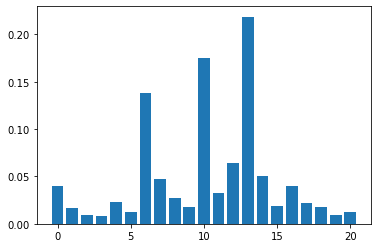

{'xgboost Feature': {'Feature 13': 0.2185927}}
the score is 0.9732392478032491 with std of 0.0036109463825564872
(10127,)
auc 0.9694731572931535 got added
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      8500
           1       0.93      0.88      0.91      1627

    accuracy                           0.97     10127
   macro avg       0.95      0.93      0.94     10127
weighted avg       0.97      0.97      0.97     10127

                 Predicted Negative  Predicted Positive
Actual Negative                8392                 108
Actual Positive                 191                1436

The FN is  191
The tn is  8392
The tp is  1436
The fp is  108

The precision is:  0.9300518134715026
The recall is:  0.8826060233558697
The f1 score is:  0.9057079785556607
Area under the Receiver Operating Characteristic curve: 0.9349500705014643

The averagve area under the precision-recall curve is: 0.9694731572931535 with std of 0.0

The avera

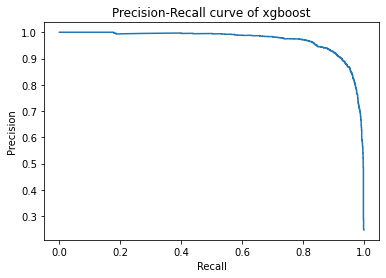

In [11]:
# define the scoring method
scoring = 'accuracy'
number_repeat = 1 #minimum is 1
score_dict = {}
auc_dict = {}

# define models to train
names = [
#        'Decision Tree',
#          'SVM Linear',
#          'SVM RBF', 
#          'SVM Sigmoid'
#         'BaggingClassifier',
#         'RandomForest',
#         'Adaboost',
            'xgboost'
        ]

# build classifiers
classifiers = [
#     tree.DecisionTreeClassifier(),
#     SVC(kernel='linear', C = 2.0, gamma='scale'),
#     SVC(kernel='rbf', C = 2.0, gamma='scale'),
#     SVC(kernel='sigmoid', C = 2.0, gamma='scale'),
#     BaggingClassifier(n_estimators=200, oob_score = True),
#     RandomForestClassifier(n_estimators=300, max_features = "sqrt", oob_score = True),
#     AdaBoostClassifier(n_estimators=400, learning_rate = 0.6)
     xgb.XGBClassifier(objective="binary:logistic", eval_metric='mlogloss', random_state=42, use_label_encoder=False)
]

models = zip(names, classifiers)

# evaluate each model in turn
results = []
#results_2 = []
#results_3 = []

for name, model in models:
    # Use stratified k-fold cross validation to deal with imbalanced data
    print("The model running is: " + name)
    
    if name != "BaggingClassifier":
        feature_importance(name, model)
    high_low_feature(feature_dict)
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    for i in range(number_repeat):
        kfold = StratifiedKFold(n_splits=5, shuffle=True)
        scores = cross_val_score(model, X, y, cv = kfold)
        if name not in score_dict:
            score_dict[name] = [] 
        score_dict[name].append((scores.mean(), scores.std()))
        print("the score is", scores.mean(),"with std of", scores.std())
        y_pred = cross_val_predict(model, X, y, cv=kfold, method='predict_proba')[:,1]
#         y_pred = model.fit(X,y).predict_proba(X)
        print(y_pred.shape)
        if name not in auc_dict:
            auc_dict[name] = [] 
        precision, recall, thresholds = precision_recall_curve(y, y_pred)
        auc_precision_recall = auc(recall, precision)
        auc_dict[name].append(auc_precision_recall)
        print("auc", auc_precision_recall, "got added")
    
#     y_pred = model.fit(X,y).predict_proba(X)[:,1]
    y_classification = cross_val_predict(model, X, y, cv=kfold)
    y_pred = cross_val_predict(model, X, y, cv=kfold,method='predict_proba')[:,1]
    print(classification_report(y, y_classification))
    
    confusion_mat = confusion_matrix(y, y_classification)
    graph = pd.DataFrame(confusion_mat, 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])
    
    print(graph)
    print()
    fn = confusion_mat[1][0]
    tn = confusion_mat[0][0]
    tp = confusion_mat[1][1]
    fp = confusion_mat[0][1] 
    
    print("The FN is ", fn)
    print("The tn is ", tn)
    print("The tp is ", tp)
    print("The fp is ", fp)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall / (precision + recall))
    
    print()
    print("The precision is: ", precision)
    print("The recall is: ", recall)
    print("The f1 score is: ", f1_score)

    print('Area under the Receiver Operating Characteristic curve:', str(roc_auc_score(y, y_classification)))
    print()
    auc_precision_recall_mean = sum(auc_dict[name]) / len(auc_dict[name])
    auc_precision_recall_std = statistics.pstdev(auc_dict[name])
    print("The averagve area under the precision-recall curve is:", auc_precision_recall_mean, "with std of", auc_precision_recall_std)
    print()
    temp_list = score_dict[name]
    score_mean = 0
    score_std = 0
    for i in temp_list:
        score_mean += i[0]
        score_std += i[1]
    score_mean /= len(temp_list)
    score_std /= len(temp_list)
    print("The average accuracy is",score_mean,"with the std of",score_std)
    print()
    precision, recall, thresholds = precision_recall_curve(y, y_pred)
    plt.plot(recall, precision)
    plt.title("Precision-Recall curve of " + name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    print()